## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GRU, Reshape
from tensorflow.python.keras import utils
from keras.utils import to_categorical
from numpy import load
import io

### Load Spectrogram and Label Numpy Array from npy file

In [ ]:
from google.colab import files
uploaded = files.upload()

Mounted at /content/gdrive


In [ ]:
# load Spectrogam array
X = load(io.BytesIO(uploaded['mel_specs.npy']))

In [ ]:
# load Labels array
y = load(io.BytesIO(uploaded['labels.npy']))

#### Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=.2)

In [ ]:
X_test.shape

(200, 128, 660)

In [ ]:
X_train.shape

(799, 128, 660)

#### Reshaping images to be 128 x 660 x 1, where the 1 represents the single color channel

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 128, 660, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 660, 1)

#### One hot encoding our labels

In [ ]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 6.1MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=c18f5d19535b2dbfd4d0c8e513b7bdc28b50af6e71133c50aee8305df40c89c7
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15357 sha256=b6116b39bb7a07481126d3382e78de1f65fedd10322b8c20fb8db698f397060b
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


### Define the Keras Tuner Hypermodels

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(
            Conv2D(
                filters=32,
                kernel_size=(3,3),
                activation=hp.Choice(
                    'Conv_activation',
                    values=['relu', 'tanh', 'elu', 'sigmoid'],
                    default='relu'
                ),
                input_shape=self.input_shape
            )
        )
        model.add(MaxPooling2D(pool_size=(2,4)))
        model.add(
            Conv2D(
                filters=64,
                kernel_size=(3,3),
                activation=hp.Choice(
                    'Conv2_activation',
                    values=['relu', 'tanh', 'elu', 'sigmoid'],
                    default='relu'
                ),
                input_shape=self.input_shape
            )
        )
        model.add(MaxPooling2D(pool_size=(2,4)))
        model.add(Flatten())
        model.add(Dense(64, activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'elu', 'sigmoid'],
                    default='relu'
                )))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

### Setting up Random Search Optimization

In [ ]:
NUM_CLASSES = 10
INPUT_SHAPE = (128, 660, 1)
SEED = 2
HYPERBAND_MAX_EPOCHS = 25
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='research_project'
)

#### Search Space Summary

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
Conv_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'sigmoid'], 'ordered': False}
Conv2_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'sigmoid'], 'ordered': False}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'sigmoid'], 'ordered': False}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


### Hyperparameter tuning

In [ ]:
N_EPOCH_SEARCH = 25

tuner.search(X_train, y_train, epochs=N_EPOCH_SEARCH, validation_split=0.1)

Trial 20 Complete [00h 01m 01s]
val_accuracy: 0.3062500059604645

Best val_accuracy So Far: 0.3062500059604645
Total elapsed time: 00h 20m 14s
INFO:tensorflow:Oracle triggered exit


### Show a summary of the Random Search

In [ ]:
tuner.results_summary()

Results summary
Results in random_search/research_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
Conv_activation: tanh
Conv2_activation: tanh
dense_activation: elu
learning_rate: 0.0010277342442932575
Score: 0.3062500059604645
Trial summary
Hyperparameters:
Conv_activation: elu
Conv2_activation: relu
dense_activation: relu
learning_rate: 0.001382473598709221
Score: 0.2875000014901161
Trial summary
Hyperparameters:
Conv_activation: relu
Conv2_activation: elu
dense_activation: relu
learning_rate: 0.00036276965095376624
Score: 0.20000000670552254
Trial summary
Hyperparameters:
Conv_activation: relu
Conv2_activation: elu
dense_activation: elu
learning_rate: 0.00013607174450468629
Score: 0.16250000149011612
Trial summary
Hyperparameters:
Conv_activation: relu
Conv2_activation: relu
dense_activation: sigmoid
learning_rate: 0.0023360487671257027
Score: 0.13750000298023224
Trial summary
Hyperparameters:
Conv_activation: sigmoid
Con

### Retrieve the best model.

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

### Evaluate the model

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)

7/7 - 0s - loss: 1.9368 - accuracy: 0.4800


#### Print Model Accuracy

In [ ]:
print(test_acc)

0.47999998927116394


### Making predictions with the best CNN model

In [ ]:
predictions = best_model.predict(X_test, verbose=1)

7/7 [==============================] - 0s 16ms/step


### CNN Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(predictions, 1))
conf_matrix

array([[ 4,  1,  0,  3,  0,  2,  0,  0,  2,  8],
       [ 0, 18,  0,  0,  0,  1,  0,  0,  0,  1],
       [ 1,  4,  5,  0,  0,  3,  0,  0,  0,  7],
       [ 0,  1,  0,  7,  0,  1,  0,  4,  2,  5],
       [ 0,  0,  0,  1, 11,  0,  2,  2,  2,  2],
       [ 2,  5,  1,  0,  1,  8,  0,  0,  0,  3],
       [ 0,  0,  0,  0,  0,  0, 16,  0,  0,  4],
       [ 0,  0,  0,  2,  4,  0,  1,  9,  0,  4],
       [ 0,  0,  1,  4,  3,  0,  1,  3,  8,  0],
       [ 0,  2,  2,  1,  0,  0,  5,  0,  0, 10]])

In [ ]:
confusion_df = pd.DataFrame(conf_matrix)
confusion_df

,0,1,2,3,4,5,6,7,8,9
0,4,1,0,3,0,2,0,0,2,8
1,0,18,0,0,0,1,0,0,0,1
2,1,4,5,0,0,3,0,0,0,7
3,0,1,0,7,0,1,0,4,2,5
4,0,0,0,1,11,0,2,2,2,2
5,2,5,1,0,1,8,0,0,0,3
6,0,0,0,0,0,0,16,0,0,4
7,0,0,0,2,4,0,1,9,0,4
8,0,0,1,4,3,0,1,3,8,0
9,0,2,2,1,0,0,5,0,0,10


#### Matching the Encoded Labels 

In [ ]:
labels_dict = {
        0: 'blues',
        1: 'classical',
        2: 'country',
        3: 'disco',
        4: 'hiphop',
        5: 'jazz',
        6: 'metal',
        7: 'pop',
        8: 'reggae',
        9: 'rock'
    }

In [ ]:
confusion_df = confusion_df.rename(columns=labels_dict, index=labels_dict)

In [ ]:
confusion_df

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
blues,4,1,0,3,0,2,0,0,2,8
classical,0,18,0,0,0,1,0,0,0,1
country,1,4,5,0,0,3,0,0,0,7
disco,0,1,0,7,0,1,0,4,2,5
hiphop,0,0,0,1,11,0,2,2,2,2
jazz,2,5,1,0,1,8,0,0,0,3
metal,0,0,0,0,0,0,16,0,0,4
pop,0,0,0,2,4,0,1,9,0,4
reggae,0,0,1,4,3,0,1,3,8,0
rock,0,2,2,1,0,0,5,0,0,10


#### Creating a heatmap for the confusion matrix for display

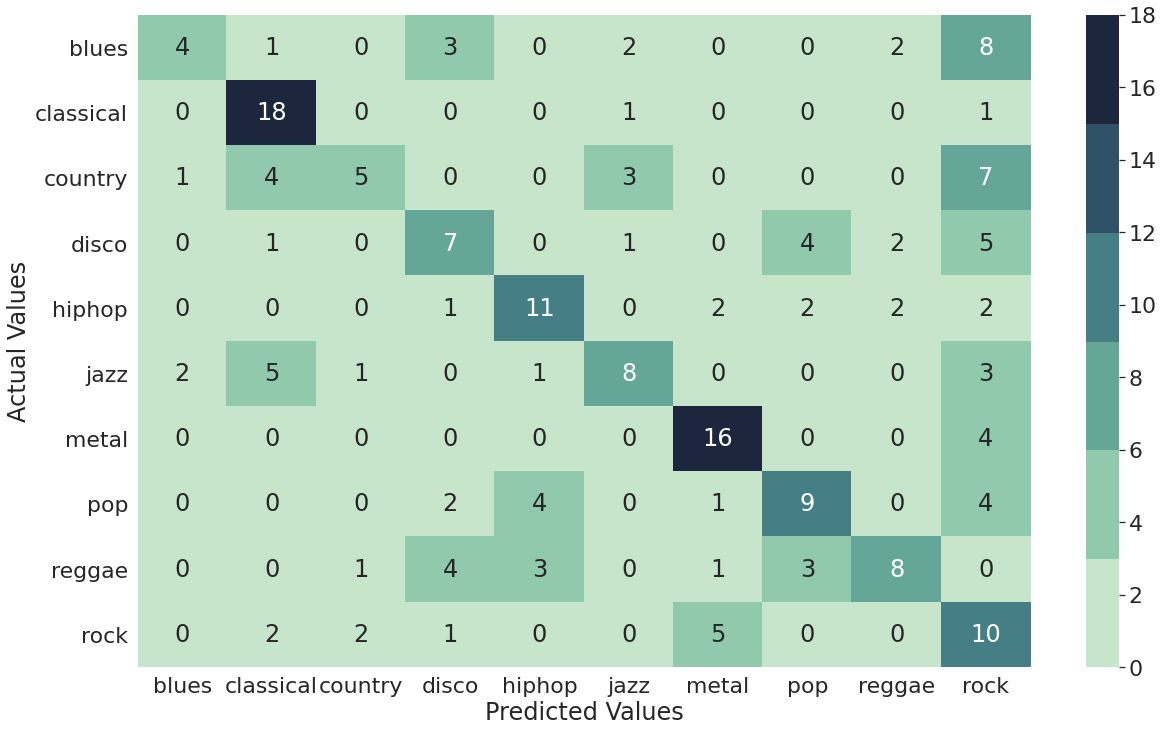

In [ ]:
plt.figure(figsize= (20,12))
sns.set(font_scale = 2);
ax = sns.heatmap(confusion_df, annot=True, cmap=sns.cubehelix_palette(rot=-.4));
ax.set(xlabel='Predicted Values', ylabel='Actual Values');

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test, 1),  np.argmax(predictions, 1)))

              precision    recall  f1-score   support

           0       0.57      0.20      0.30        20
           1       0.58      0.90      0.71        20
           2       0.56      0.25      0.34        20
           3       0.39      0.35      0.37        20
           4       0.58      0.55      0.56        20
           5       0.53      0.40      0.46        20
           6       0.64      0.80      0.71        20
           7       0.50      0.45      0.47        20
           8       0.57      0.40      0.47        20
           9       0.23      0.50      0.31        20

    accuracy                           0.48       200
   macro avg       0.51      0.48      0.47       200
weighted avg       0.51      0.48      0.47       200

